## Import modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, mutual_info_classif, RFE
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
le = LabelEncoder()
SEED = 42

## Reading dataset

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

### Dataset description

client_id - идентификатор клиента  
education - уровень образования  
sex - пол заемщика  
age - возраст заемщика  
car - флаг наличия автомобиля  
car_type - флаг автомобиля иномарки  
decline_app_cnt - количество отказанных прошлых заявок  
good_work - флаг наличия “хорошей” работы  
bki_request_cnt - количество запросов в БКИ  
home_address - категоризатор домашнего адреса  
work_address - категоризатор рабочего адреса  
income - доход заемщика  
foreign_passport - наличие загранпаспорта  
sna - связь заемщика с клиентами банка  
first_time - давность наличия информации о заемщике  
score_bki - скоринговый балл по данным из БКИ  
region_rating - рейтинг региона  
app_date - дата подачи заявки  
default - флаг дефолта по кредиту

In [4]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['default'] = 0
data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [5]:
data[data['sample'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  i

In [6]:
# Unique data by columns

data[data['sample'] == 1].nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
sample                  1
default                 2
dtype: int64

In [7]:
# Empty cells by columns

data[data['sample'] == 1].isna().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [8]:
# Main metrics of dataset

data[data['sample'] == 1].describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.0,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,1.0,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.0,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,1.0,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,1.0,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.0,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.0,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.0,1.000000


In [9]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
41142,72285,20MAR2014,GRD,F,54,Y,N,0,0,-2.096063,2,50,1,2,25000,1,3,N,1,0
22079,90019,06APR2014,UGR,F,49,N,N,0,0,-3.011824,4,70,2,3,30000,4,1,N,0,0
25843,31788,07FEB2014,SCH,F,45,N,N,0,0,-1.376807,0,60,2,3,20000,1,3,N,0,0
65549,19068,26JAN2014,SCH,M,47,Y,Y,0,0,-1.820205,3,50,1,2,30000,2,3,Y,1,0
76654,18981,26JAN2014,SCH,F,62,N,N,0,0,-2.498967,0,80,2,3,40000,1,4,N,1,0


## Function list

In [10]:
def outliers(col, col_name):
    '''Function to count outliers'''
    
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = pd.DataFrame(col[((col < (Q1 - 1.5 * IQR)) 
                                       | (col > (Q3 + 1.5 * IQR)))]).count()
    print(f'In column {outliers_count.index[0]} {outliers_count[0]} ouliers')


def percent_of_target(col1, col2):
    '''Little func to display dictrib'''
    
    display(pd.crosstab(col1, col2, normalize='index'))
    

def main_dataframe_processing(data):
    '''Function for processing dataframe'''
    
    # Ident minmax scaler
    minmax_scaler = MinMaxScaler()
    
    # Columns lists
    bin_list = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
    cat_list = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'education', 
                'car_sex', 'car_and_type', 'week_num', 'week_day']
    num_list_for_log = ['age', 'income', 'score_bki', 'client_id']
    
    # Scaling score_bki
    data['score_bki'] = minmax_scaler.fit_transform(data['score_bki'].values.reshape(-1, 1))
           
    # For Education adding NaNs column and filling NaNs by 'NOED'
    data['education_NaN'] = (data['education'].isna()).astype('int32')
    data['education'].fillna('NOED', inplace=True)
    data['cat_education'] = le.fit_transform(data['education'])
    
    # Columns for mark outliers
    for col in ['score_bki', 'income', 'bki_request_cnt']:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        data[col+'_outliers'] = ((data[col] < (Q1 - 1.5 * IQR)) 
                                 | (data[col] > (Q3 + 1.5 * IQR))).astype('int32')
    
    # Split age column to categories
    cut_bins = list([x for x in range(19, 80, 5)])
    cut_labels = list([x for x in range(len(cut_bins)-1)])
    data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels).astype('int32')
    
    # Reduce categories
    mask1 = (data['bki_request_cnt'] > 18)
    mask2 = (data['bki_request_cnt'].between(15, 18, inclusive='both'))
    mask3 = (data['bki_request_cnt'].between(12, 14, inclusive='both'))
    mask4 = (data['bki_request_cnt'].between(9, 11, inclusive='both'))
    mask5 = (data['bki_request_cnt'].between(6, 8, inclusive='both'))
    mask6 = (data['bki_request_cnt'].between(4, 5, inclusive='both'))

    data.loc[mask6, 'bki_request_cnt'] = 4
    data.loc[mask5, 'bki_request_cnt'] = 5
    data.loc[mask4, 'bki_request_cnt'] = 6
    data.loc[mask3, 'bki_request_cnt'] = 7
    data.loc[mask2, 'bki_request_cnt'] = 8
    data.loc[mask1, 'bki_request_cnt'] = 9
    
    mask = (data['decline_app_cnt'] > 3)
    data.loc[mask, 'decline_app_cnt'] = 3
    
    # Combine 2 columns
    data['car_sex'] = data['sex'] + data['car']
    data['car_and_type'] = data['car'] + data['car_type']
    
    # Date processing
    data['app_date'] = pd.to_datetime(data['app_date'])
    data['week_num'] = data['app_date'].dt.isocalendar().week
    data['week_day'] = data['app_date'].dt.day_of_week
    data['month_day'] = data['app_date'].dt.day
    data['year_day'] = data['app_date'].dt.day_of_year
    data['month_num'] = data['app_date'].dt.month
    
    # Logarithm columns
    for col in ['age', 'income', 'score_bki', 'client_id']:
        data[col+'_log'] = np.log(data[col] + 1)
    
    # Dummies
    dummies_columns = cat_list + bin_list
    dummies_data = pd.get_dummies(data[dummies_columns], columns=dummies_columns)
    data = pd.concat([data, dummies_data], axis=1)
    
    # Deleting non-usefull columns
    drop_lst = cat_list + bin_list + num_list_for_log
    
    data = data.drop(drop_lst, axis=1)
    
    return data


def normalize(train_data, valid_data, test_data):
    '''Normalization of DataSet'''
    
    robust_scaler = RobustScaler()
    
    y_train = train_data['default'].values
    X_train = robust_scaler.fit_transform(train_data.drop(columns='default', axis=1))
    y_valid = valid_data['default'].values
    X_valid = robust_scaler.transform(valid_data.drop(columns='default', axis=1))
    X_test = robust_scaler.transform(test_data.drop(columns='default', axis=1))
    return X_train, X_valid, y_train, y_valid, X_test


def model(X_train, X_valid, y_train, y_valid, class_w=None):
    '''Func fot testing model'''
    
    lr = LogisticRegression(solver='liblinear', max_iter=150, class_weight=class_w, 
                            random_state=SEED)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_valid)
    y_pred_proba = lr.predict_proba(X_valid)
    
    print(f1_score(y_valid, y_pred))
    print(classification_report(y_valid, y_pred))
    print(cross_val_score(lr, X_train, y_train, scoring='f1', cv=10))
    
    roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:,1])
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    
def display_countplot_sep_by_def_and_sex(data, col):
    '''Ploting countplot separated by default and by sex'''
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 2))
    sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
                  x=col, hue='sex', ax=ax[0]).set_title('Default 0')
    sns.countplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
                  x=col, hue='sex', ax=ax[1]).set_title('Default 1')
    plt.show()
    
    
def display_countplot_sep_by_def(data, col):
    '''Ploting countpot separated by default'''
    fig, ax = plt.subplots(1, 2, figsize=(12, 2))
    sns.countplot(data=data[(data['sample'] == 1)], x=col, hue='default', ax=ax[0]).set_title('Distrib by Default')
    sns.countplot(data=data[(data['sample'] == 1)], x=col, ax=ax[1]).set_title(f'Distrib by {col}')
    plt.show()
    
    
def display_histplot_sep_by_def_and_sex(data, col):
    '''Ploting histplt separated by default and by sex'''
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 2))
    sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 0)], 
                 x=col, hue='sex', multiple='dodge', ax=ax[0]).set_title('Default 0')
    sns.histplot(data=data[(data['sample'] == 1) & (data['default'] == 1)], 
                 x=col, hue='sex', multiple='dodge', ax=ax[1]).set_title('Default 1')
    plt.show()
    
    
def correlation_plot(data, cols):
    '''Ploting correlation matrix'''
    
    sns.set(font_scale=1)
    plt.subplots(figsize=(12, 12))
    sns.heatmap(data[data['sample'] == 1][cols].corr(), square=True, 
                annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")
    plt.show()

### Setup

In [11]:
bin_list = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_list = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'education', 
            'week_num', 'week_day']
num_list_for_log = ['age', 'income', 'score_bki', 'client_id']

## EDA

### Target column - 'default'

In [12]:
data[data['sample'] == 1]['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

So, there is imbalance in target. Later I'll try to fix it

### Numerical columns

#### Age

This column doen't have NaN. So, let's look at outliers and distribution by Default.

In [13]:
outliers(data[data['sample'] == 1]['age'], 'age')

In column age 0 ouliers


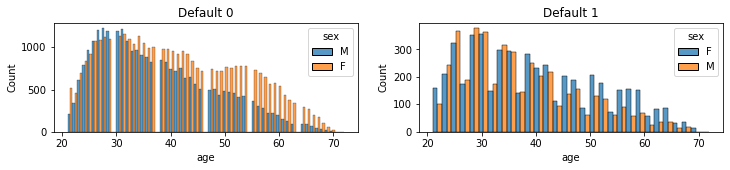

In [14]:
display_histplot_sep_by_def_and_sex(data, 'age')

Intresting. Kredit for women more ofter had been approved. Denied the same.

In [15]:
print(f'Min Age is {data[data["sample"] == 1]["age"].min()}')
print(f'Max Age is {data[data["sample"] == 1]["age"].max()}')

Min Age is 21
Max Age is 72


Split it on categories by 5 years

In [16]:
cut_bins = list([x for x in range(19, 80, 5)])
cut_labels = list([x for x in range(len(cut_bins)-1)])
data['cat_age'] = pd.cut(data['age'], bins=cut_bins, labels=cut_labels).astype('int32')

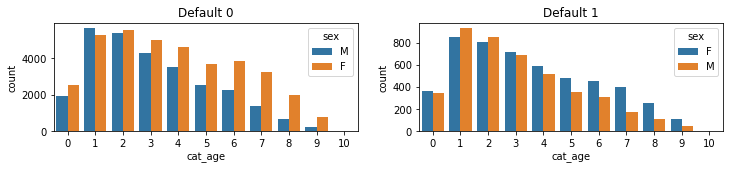

In [17]:
display_countplot_sep_by_def_and_sex(data, 'cat_age')

In [18]:
percent_of_target(data[data['sample'] == 1]['cat_age'], data[data['sample'] == 1]['default'])

default,0,1
cat_age,,
0,0.862229,0.137771
1,0.859879,0.140121
2,0.868963,0.131037
3,0.868765,0.131235
4,0.880069,0.119931
5,0.881624,0.118376
6,0.888581,0.111419
7,0.889210,0.110790
8,0.876908,0.123092


In [19]:
data['age'] = np.log(data['age'] + 1)

About equal distribution by categories over Default column.

#### score_bki

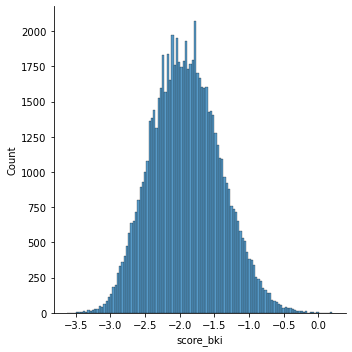

In [20]:
sns.displot(data[data['sample'] == 1]['score_bki'])
plt.show()

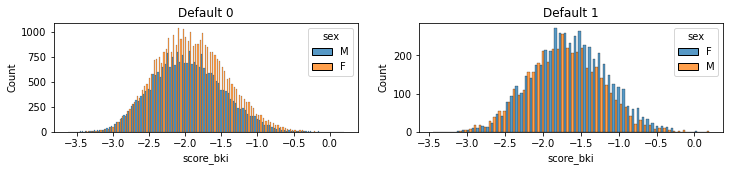

In [21]:
display_histplot_sep_by_def_and_sex(data, 'score_bki')

This column doen't have NaN. So, let's look at outliers and distribution by Default

In [22]:
outliers(data[data['sample'] == 1]['score_bki'], 'score_bki')

In column score_bki 351 ouliers


Let's make column to mark outliers.

In [23]:
Q1 = data[data['sample'] == 1]['score_bki'].quantile(0.25)
Q3 = data[data['sample'] == 1]['score_bki'].quantile(0.75)
IQR = Q3 - Q1
data['score_bki_outliers'] = ((data['sample'] == 1) & ((data['score_bki'] < (Q1 - 1.5 * IQR)) | (data['score_bki'] > (Q3 + 1.5 * IQR)))).astype('int32')

#### decline_app_cnt

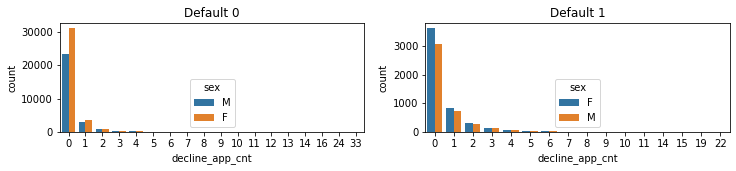

In [24]:
display_countplot_sep_by_def_and_sex(data, 'decline_app_cnt')

Count sum of each group

In [25]:
data[data['sample'] == 1]['decline_app_cnt'].value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

Let's group tails. Leave only 5 groups.

In [26]:
mask = (data['decline_app_cnt'] > 4)
data.loc[mask, 'decline_app_cnt'] = 4

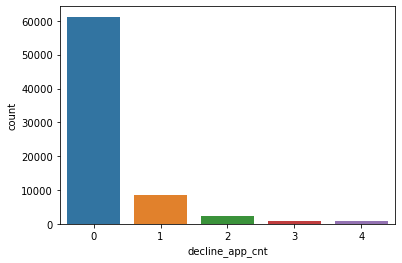

In [27]:
sns.countplot(x='decline_app_cnt', data=data[data['sample'] == 1])
plt.show()

In [28]:
percent_of_target(data[data['sample'] == 1]['decline_app_cnt'], data[data['sample'] == 1]['default'])

default,0,1
decline_app_cnt,,
0,0.890466,0.109534
1,0.812195,0.187805
2,0.756483,0.243517
3,0.726467,0.273533
4,0.703794,0.296206


#### bki_request_cnt

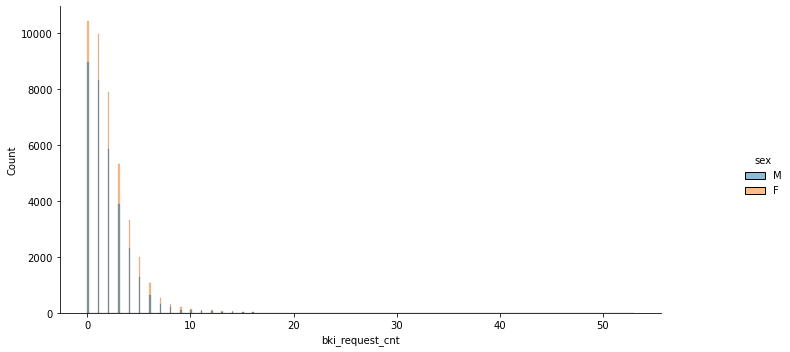

In [29]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

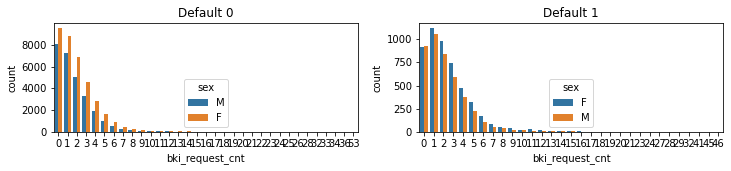

In [30]:
display_countplot_sep_by_def_and_sex(data, 'bki_request_cnt')

In [31]:
data[data['sample'] == 1]['bki_request_cnt'].value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [32]:
mask1 = (data['bki_request_cnt'] > 18)
mask2 = (data['bki_request_cnt'].between(15, 18, inclusive='both'))
mask3 = (data['bki_request_cnt'].between(12, 14, inclusive='both'))
mask4 = (data['bki_request_cnt'].between(9, 11, inclusive='both'))
mask5 = (data['bki_request_cnt'].between(6, 8, inclusive='both'))
mask6 = (data['bki_request_cnt'].between(4, 5, inclusive='both'))

data.loc[mask6, 'bki_request_cnt'] = 4
data.loc[mask5, 'bki_request_cnt'] = 5
data.loc[mask4, 'bki_request_cnt'] = 6
data.loc[mask3, 'bki_request_cnt'] = 7
data.loc[mask2, 'bki_request_cnt'] = 8
data.loc[mask1, 'bki_request_cnt'] = 9

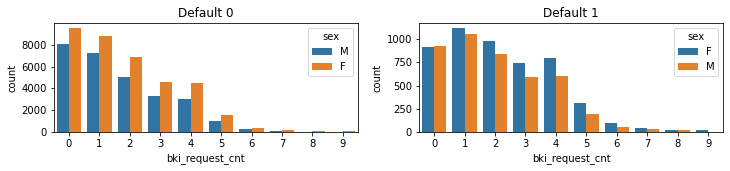

In [33]:
display_countplot_sep_by_def_and_sex(data, 'bki_request_cnt')

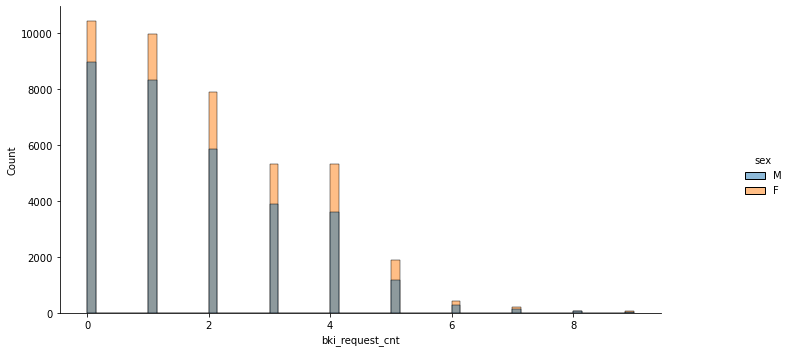

In [34]:
pl = sns.displot(x='bki_request_cnt', data=data[data['sample'] == 1], hue='sex')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

#### Income

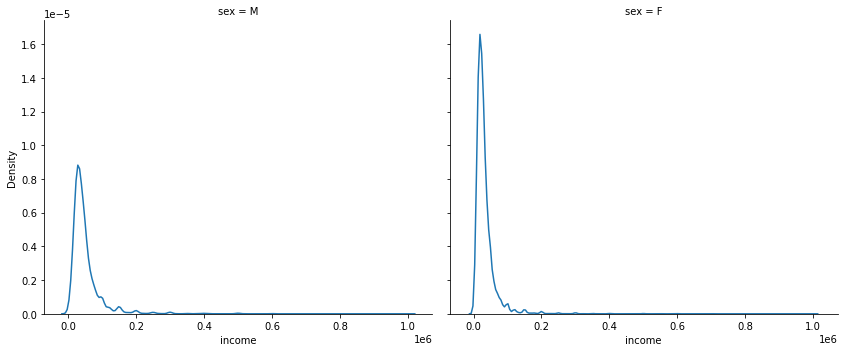

In [35]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

In [36]:
outliers(data[data['sample'] == 1]['income'], 'income')

In column income 4695 ouliers


In [37]:
Q1 = data[data['sample'] == 1]['income'].quantile(0.25)
Q3 = data[data['sample'] == 1]['income'].quantile(0.75)
IQR = Q3 - Q1
data['income_outliers'] = ((data['sample'] == 1) & ((data['income'] < (Q1 - 1.5 * IQR)) | (data['income'] > (Q3 + 1.5 * IQR)))).astype('int32')

25 quatile = 20000, 75 - 48000. Make cat column from income with step 5000. < 20000 - 0, > 48000 max cat

In [38]:
cut_income_bins = [0, 20000, 25000, 30000, 35000, 40000, 45000, 48000, 1000001]
cut_income_labels = [0, 1, 2, 3, 4, 5, 6, 7]

data['cat_income'] = pd.cut(data['income'], cut_income_bins, labels=cut_income_labels, right=False).astype('int32')

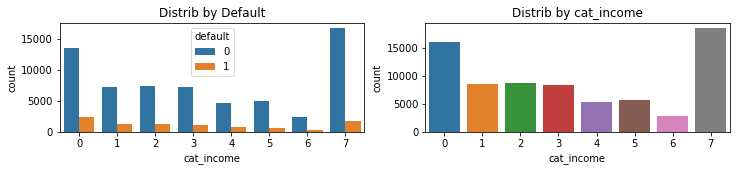

In [39]:
display_countplot_sep_by_def(data, 'cat_income')

In [40]:
percent_of_target(data[data['sample'] == 1]['cat_income'], data[data['sample'] == 1]['default'])

default,0,1
cat_income,,
0,0.853437,0.146563
1,0.849900,0.150100
2,0.858661,0.141339
3,0.873969,0.126031
4,0.859730,0.140270
5,0.883493,0.116507
6,0.875133,0.124867
7,0.907273,0.092727


In [41]:
data['income'] = np.log(data['income'] + 1)

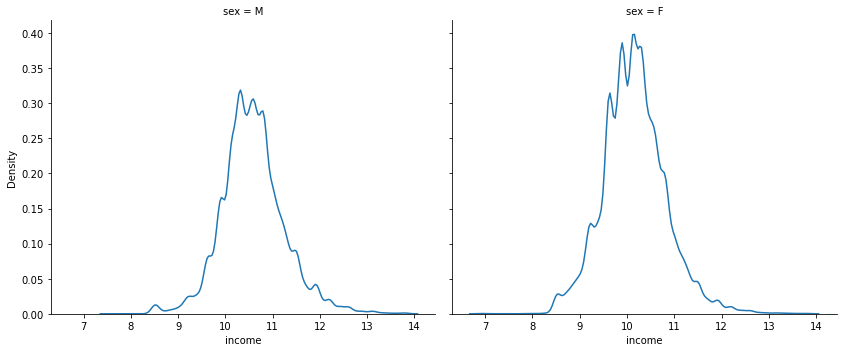

In [42]:
pl = sns.displot(data = data[data['sample'] == 1], x='income', col='sex', kind='kde')
pl.fig.set_figwidth(12)
pl.fig.set_figheight(5)

### Binary columns

#### sex

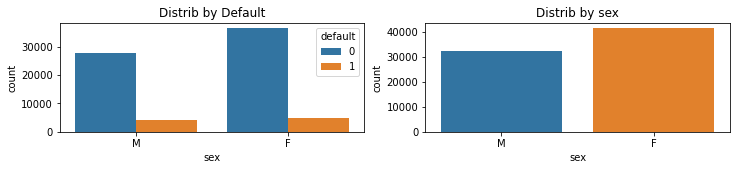

In [43]:
display_countplot_sep_by_def(data, 'sex')

#### car

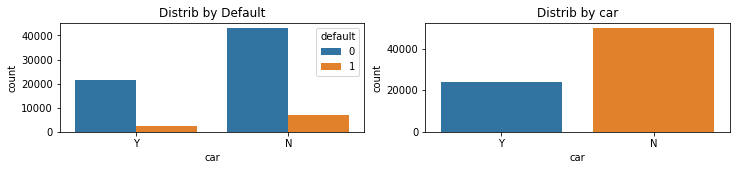

In [44]:
display_countplot_sep_by_def(data, 'car')

#### car_type

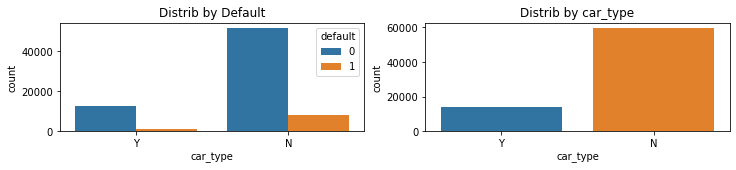

In [45]:
display_countplot_sep_by_def(data, 'car_type')

#### good_work

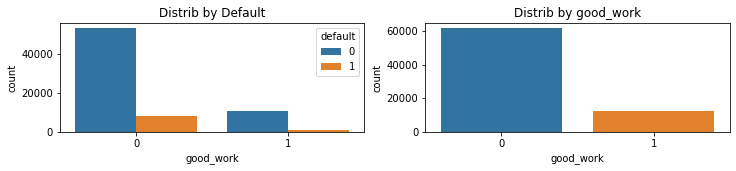

In [46]:
display_countplot_sep_by_def(data, 'good_work')

#### foreign_passport

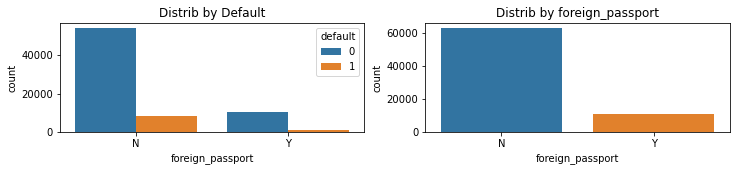

In [47]:
display_countplot_sep_by_def(data, 'foreign_passport')

### Categorical columns

#### Education

In [48]:
data[(data['sample'] == 1)]['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

This column has empty cells. Count them and fill by mode. There is only 307 in train. But first I make new column with marks of empty cells (like for outliers)

In [49]:
data['education_NaN'] = (data['education'].isna()).astype('int32')

In [50]:
data['education'].fillna('NOED', inplace=True)

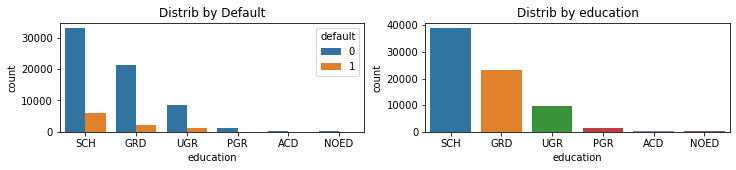

In [51]:
display_countplot_sep_by_def(data, 'education')

In [52]:
percent_of_target(data[(data['sample'] == 1)]['education'], data[(data['sample'] == 1)]['default'])

default,0,1
education,,
ACD,0.958763,0.041237
GRD,0.909908,0.090092
NOED,0.885993,0.114007
PGR,0.935561,0.064439
SCH,0.849408,0.150592
UGR,0.868480,0.131520


In [53]:
data['education'] = le.fit_transform(data['education'])

Further I'll decide to do dummies or change cal names to numeric

#### first_time

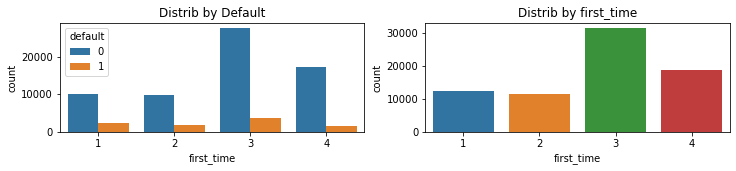

In [54]:
display_countplot_sep_by_def(data, 'first_time')

In [55]:
percent_of_target(data[(data['sample'] == 1)]['first_time'], data[(data['sample'] == 1)]['default'])

default,0,1
first_time,,
1,0.813874,0.186126
2,0.844571,0.155429
3,0.879731,0.120269
4,0.917970,0.082030


#### sna

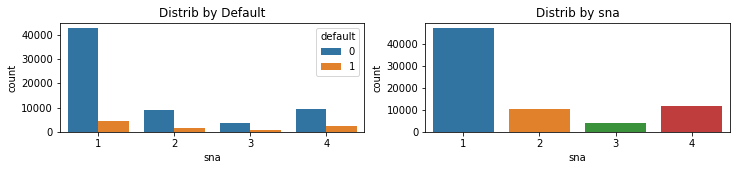

In [56]:
display_countplot_sep_by_def(data, 'sna')

In [57]:
percent_of_target(data[(data['sample'] == 1)]['sna'], data[(data['sample'] == 1)]['default'])

default,0,1
sna,,
1,0.901799,0.098201
2,0.850179,0.149821
3,0.842348,0.157652
4,0.788493,0.211507


#### work_address

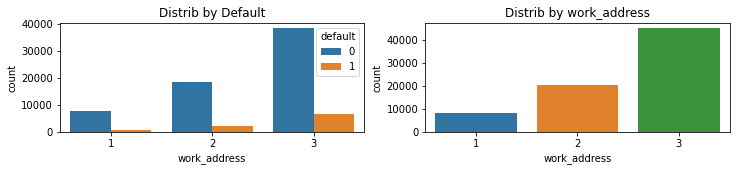

In [58]:
display_countplot_sep_by_def(data, 'work_address')

In [59]:
percent_of_target(data[(data['sample'] == 1)]['work_address'], data[(data['sample'] == 1)]['default'])

default,0,1
work_address,,
1,0.925846,0.074154
2,0.897493,0.102507
3,0.852043,0.147957


#### home_address

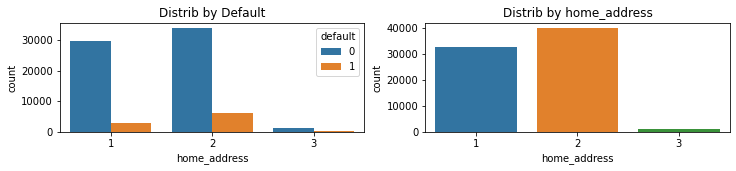

In [60]:
display_countplot_sep_by_def(data, 'home_address')

In [61]:
percent_of_target(data[(data['sample'] == 1)]['home_address'], data[(data['sample'] == 1)]['default'])

default,0,1
home_address,,
1,0.907104,0.092896
2,0.844854,0.155146
3,0.883943,0.116057


#### region_rating

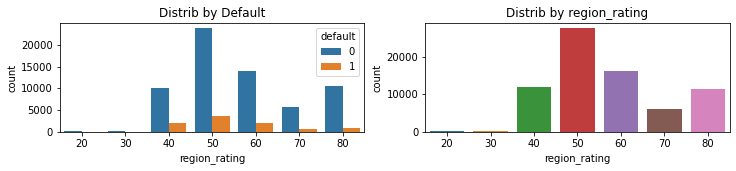

In [62]:
display_countplot_sep_by_def(data, 'region_rating')

In [63]:
percent_of_target(data[(data['sample'] == 1)]['region_rating'], data[(data['sample'] == 1)]['default'])

default,0,1
region_rating,,
20,0.786408,0.213592
30,0.810000,0.190000
40,0.830298,0.169702
50,0.863859,0.136141
60,0.871166,0.128834
70,0.907566,0.092434
80,0.926846,0.073154


### Date column

In [64]:
data['app_date'] = pd.to_datetime(data['app_date'])

In [65]:
data['week_num'] = data['app_date'].dt.isocalendar().week
data['week_day'] = data['app_date'].dt.day_of_week
data['month_day'] = data['app_date'].dt.day
data['year_day'] = data['app_date'].dt.day_of_year
data['month_num'] = data['app_date'].dt.month
data['bday'] = data['week_day'].apply(lambda x: 1 if x not in [5, 6] else 0)

### Correlation

#### Num columns

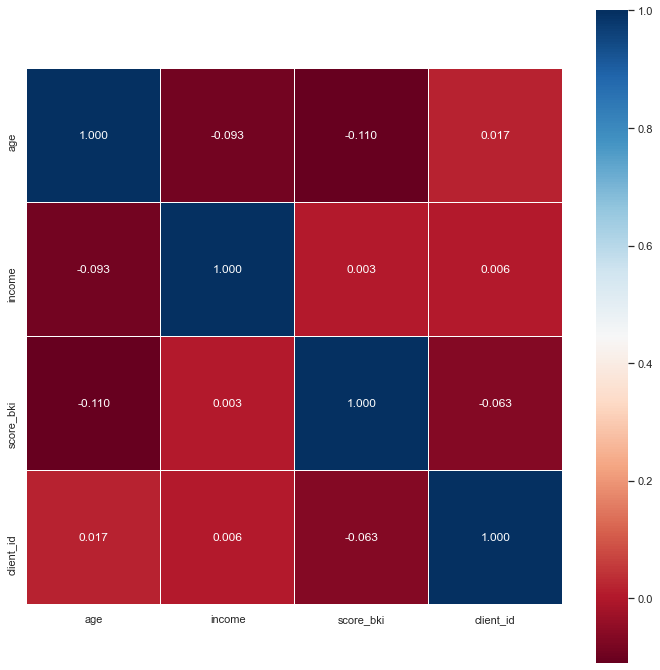

In [66]:
correlation_plot(data, num_list_for_log)

#### Cat columns

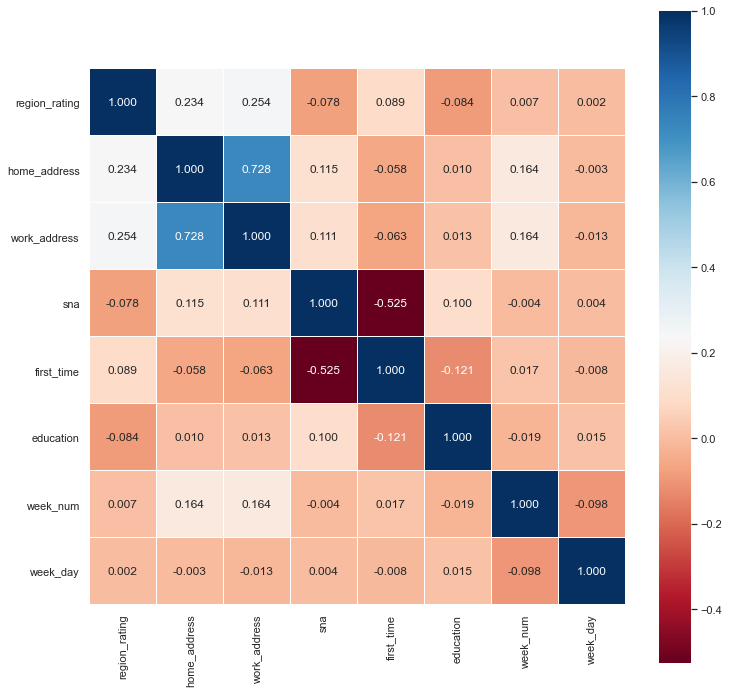

In [67]:
correlation_plot(data, cat_list)

Normal correlation over all columns. But Home and Work address have over 0.7 It's understandeble. But I leave all of them (tried to delete one but metric fall)

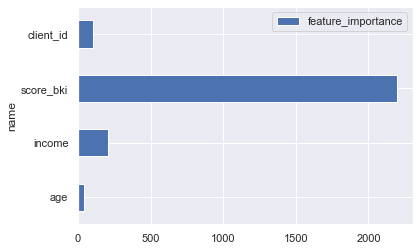

In [68]:
num_df = pd.DataFrame()
num_df['name']= np.array(num_list_for_log)
num_df['feature_importance']= f_classif(data[num_list_for_log], data['default'])[0]
num_df.plot(x="name", y="feature_importance", kind="barh")
plt.show()

<AxesSubplot:>

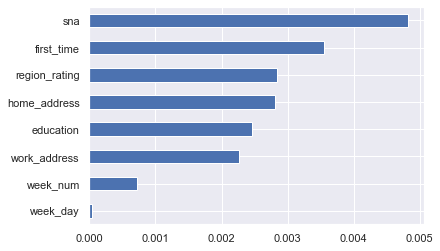

In [69]:
imp_cat = pd.Series(mutual_info_classif(data[cat_list], data['default'],
                                     discrete_features =True), index = cat_list)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Modeling

### read data and apply processing function

In [70]:
new_train_data = main_dataframe_processing(df_train)
new_test_data = main_dataframe_processing(df_test)

In [71]:
new_test_data.shape

(36349, 87)

### normalization and balansing

Deleting all non_numeric columns and split to train and test

In [72]:
new_train_data = new_train_data._get_numeric_data()
new_test_data = new_test_data._get_numeric_data()
new_train_data = new_train_data.drop(columns=['sample'], axis=1)
new_test_data = new_test_data.drop(columns=['sample'], axis=1)

In [73]:
new_train_data[new_train_data['default'] == 1].sample(5)

,decline_app_cnt,bki_request_cnt,default,education_NaN,cat_education,score_bki_outliers,income_outliers,bki_request_cnt_outliers,cat_age,month_day,year_day,month_num,age_log,income_log,score_bki_log,client_id_log,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,education_ACD,education_GRD,education_NOED,education_PGR,education_SCH,education_UGR,car_sex_FN,car_sex_FY,car_sex_MN,car_sex_MY,car_and_type_NN,car_and_type_YN,car_and_type_YY,week_num_1,week_num_2,week_num_3,week_num_4,week_num_5,week_num_6,week_num_7,week_num_8,week_num_9,week_num_10,week_num_11,week_num_12,week_num_13,week_num_14,week_num_15,week_num_16,week_num_17,week_num_18,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,sex_F,sex_M,car_N,car_Y,car_type_N,car_type_Y,good_work_0,good_work_1,foreign_passport_N,foreign_passport_Y
64209,1,0,1,0,4,0,0,0,3,4,35,2,3.637586,10.463132,0.294440,10.259867,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
57726,0,0,1,0,4,0,0,0,2,6,65,3,3.433987,9.680406,0.435435,10.974934,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0
73715,3,4,1,0,1,0,0,0,6,8,39,2,3.951244,10.308986,0.449370,10.392313,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
37032,0,0,1,0,4,0,0,0,5,31,31,1,3.850148,9.615872,0.378608,10.099548,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0
12897,0,0,1,0,4,0,0,0,7,18,108,4,4.043051,9.692828,0.474341,11.525190,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0


Split

In [74]:
train, valid = train_test_split(new_train_data, test_size=0.20, random_state=SEED)

Normalize train and test

In [75]:
X_train, X_valid, y_train, y_valid, X_test = normalize(train, valid, new_test_data)

SMOTE

In [76]:
sm = SMOTE(sampling_strategy='minority', random_state=SEED)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

RandomOverSampler

In [77]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=SEED)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

BorderlineSMOTE

In [78]:
smBL = BorderlineSMOTE(sampling_strategy='minority', random_state=SEED)
X_train_smBL, y_train_smBL = smBL.fit_resample(X_train, y_train)

### Models

#### LR (basic - no balance)

0.046583850931677016
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     12933
           1       0.43      0.02      0.05      1827

    accuracy                           0.88     14760
   macro avg       0.65      0.51      0.49     14760
weighted avg       0.82      0.88      0.82     14760

[0.04950495 0.06516291 0.05025126 0.06508135 0.06724782 0.06007509
 0.03802281 0.0425     0.03544304 0.04755945]


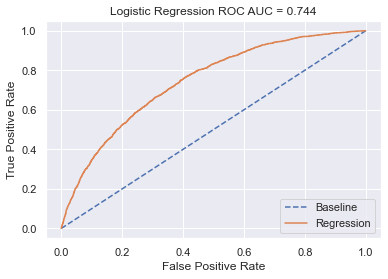

In [79]:
model(X_train, X_valid, y_train, y_valid)

#### LR with SMOTE

0.33725061492210984
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.73     14760

[0.66536318 0.68433782 0.69919622 0.68826066 0.70258869 0.69096099
 0.69023666 0.68189233 0.69788606 0.70211132]


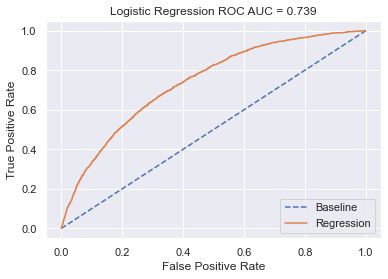

In [80]:
model(X_train_oversampled, X_valid, y_train_oversampled, y_valid)

#### LR with RandomOverSampler

0.33651904697805896
              precision    recall  f1-score   support

           0       0.94      0.66      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

[0.66873485 0.66744799 0.66077498 0.66776539 0.66908378 0.67013287
 0.66898955 0.66640829 0.66505137 0.6742846 ]


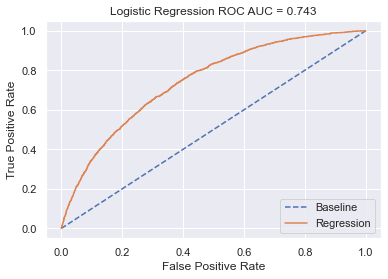

In [81]:
model(X_train_ros, X_valid, y_train_ros, y_valid)

#### LR with BorderlineSMOTE

0.3430374300874803
              precision    recall  f1-score   support

           0       0.93      0.69      0.80     12933
           1       0.23      0.65      0.34      1827

    accuracy                           0.69     14760
   macro avg       0.58      0.67      0.57     14760
weighted avg       0.85      0.69      0.74     14760

[0.65562249 0.69017682 0.72443772 0.71822679 0.73408311 0.71877671
 0.72044957 0.71693097 0.71981043 0.72500719]


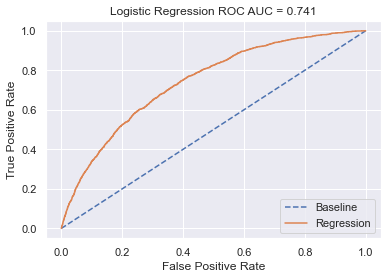

In [82]:
model(X_train_smBL, X_valid, y_train_smBL, y_valid)

#### LR with class_weight param = 'balanced'

0.33761319097175296
              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.22      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.85      0.67      0.72     14760

[0.34412955 0.33855586 0.31879195 0.34926959 0.34905336 0.33444593
 0.33288319 0.33513149 0.34416446 0.34175026]


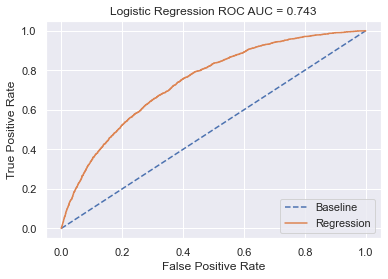

In [83]:
model(X_train, X_valid, y_train, y_valid, 'balanced')

In [84]:
# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
# model_1 = LogisticRegression(solver='liblinear', max_iter=150, class_weight='balanced')
# for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
#     X_train = X[train_index]
#     y_train = y[train_index]
#     X_test = X[test_index]
#     y_test = y[test_index]
#     sm = SMOTE(sampling_strategy='minority', random_state=SEED)
#     # sm = RandomOverSampler(sampling_strategy='minority', random_state=SEED)
#     # sm = BorderlineSMOTE(sampling_strategy='minority', random_state=SEED)
#     X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
#     # model_1.fit(X_train, y_train)  
#     model_1.fit(X_train_oversampled, y_train_oversampled)  
#     y_pred = model_1.predict(X_test)
#     print(f'For fold {fold}:')
#     print(f'Accuracy: {model_1.score(X_test, y_test)}')
#     print(f'f-score: {f1_score(y_test, y_pred)}')

### Find hyperparameters

In [85]:
# param_grid = [
#         {'penalty': ['l1'],
#          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#          'solver': ['liblinear'],
#          'class_weight': [None, 'balanced'],
#          'multi_class': ['auto', 'ovr'],
#          'max_iter': [500],
#          'tol': [1e-3]},
#         {'penalty': ['l2'],
#          'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#          'class_weight': [None, 'balanced'],
#          'multi_class': ['auto', 'ovr'],
#          'max_iter': [500],
#          'tol': [1e-3]},
#         {'penalty': ['none'],
#          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
#          'class_weight': [None, 'balanced'],
#          'multi_class': ['auto', 'ovr'],
#          'max_iter': [500],
#          'tol': [1e-3]},
#     ]

In [86]:
# mod = LogisticRegression(solver='liblinear')
# mod.fit(X_train_smBL, y_train_smBL)

In [87]:
# grid_search = GridSearchCV(mod, param_grid, scoring='f1', n_jobs=-1, cv=5)
# grid_search.fit(X_train_smBL, y_train_smBL)
# mod = grid_search.best_estimator_


# best_parameters = mod.get_params()
# for param_name in sorted(best_parameters.keys()):
#     print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [88]:
# mod.fit(X_train_smBL, y_train_smBL)

In [89]:
# LogReg = LogisticRegression(C=100, class_weight='balanced', max_iter=500, multi_class='ovr', 
#                             penalty='l2', random_state=42, solver='sag', tol=0.001, intercept_scaling=1)
# LogReg.fit(X_train_smBL, y_train_smBL)

# y_pred = LogReg.predict(X_valid)
# y_pred_proba = LogReg.predict_proba(X_valid)

# Y_pred = LogReg.predict(X_valid)
# cnf_matrix = confusion_matrix(y_valid, y_pred)
# f1_score_basic = f1_score(y_valid, y_pred)
# classification_report_basic = classification_report(y_valid, y_pred)
# print(f1_score_basic)
# print(classification_report_basic)
    
# roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
# plt.figure()
# plt.plot([0, 1], label='Baseline', linestyle='--')
# fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba[:,1])
# plt.plot(fpr, tpr, label = 'Regression')
# plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc = 'lower right')
# plt.show()

# print(cross_val_score(LogReg, X_train_smBL, y_train_smBL, scoring='f1', cv=10))

In [90]:
model = LogisticRegression(C=100, class_weight='balanced', max_iter=500, multi_class='ovr', 
                           solver='sag', tol=0.001)
model.fit(X_train_smBL, y_train_smBL)

LogisticRegression(C=100, class_weight='balanced', max_iter=500,
                   multi_class='ovr', solver='sag', tol=0.001)

[train] F1-score = 0.71 +/- 0.00
[valid] F1-score = 0.71 +/- 0.01


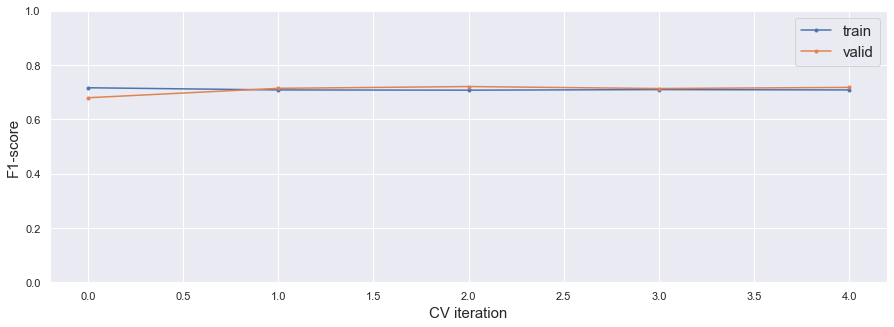

In [91]:
cv_metrics = cross_validate(model, X_train_smBL, y_train_smBL, cv=5, scoring='f1_micro', return_train_score=True)

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)
    
plot_cv_metrics(cv_metrics)

In [92]:
f1_max = 0
th = 0
pred_proba_df = pd.DataFrame(model.predict_proba(X_valid))
threshold_list = [x/100 for x in range(5, 100, 5)]
for i in threshold_list:
    y_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0).values[:, 1]
    test_f1_score = f1_score(y_valid, y_pred)
    if test_f1_score > f1_max:
        f1_max = test_f1_score
        th = i
print(f'Max F1 score is {f1_max} with {th} threshold')

Max F1 score is 0.3565512048192771 with 0.6 threshold


In [93]:
f1_max_fine = 0
th_fine = 0
pred_proba_df = pd.DataFrame(model.predict_proba(X_valid))
threshold_list = [x/100 for x in range(int(th*100 - 10), int(th*100 + 10))]
for i in threshold_list:
    y_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0).values[:, 1]
    test_f1_score = f1_score(y_valid, y_pred)
    if test_f1_score > f1_max_fine:
        f1_max_fine = test_f1_score
        th_fine = i
print(f'Max F1 score is {f1_max_fine} with {th_fine} threshold')

Max F1 score is 0.3565512048192771 with 0.6 threshold


In [94]:
pred_proba_df = pd.DataFrame(model.predict_proba(X_test))
y_submit = pred_proba_df.applymap(lambda x: 1 if x > th_fine else 0).values[:, 1]

In [95]:
y_submit.shape

(36349,)

In [96]:
sample_submission = pd.read_csv('/kaggle/input/sf-scoring/sample_submission.csv')
sample_submission['default'] = y_submit
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/sf-scoring/sample_submission.csv'

## Conclusions

1. Данные на вход были достаточно чистыми. И числовые и категориальные признаки были в рамках валидных значений. Только один признак (education) содержал NaNы. Заменил на новый вид и сделал признак NaNов. Замена на наоболее частое значение или наиболее близкое ничего не дала.
2. В некоторых числовых признаках содержались выбросы. Также пометил их в отдельных признаках. Что то делать с ними не стал, так как предполагаю, что это нормальные данные. Также из числовые признаков дополнительно создал категории.
3. Некоторые категориальные признаки подрезал по количеству категорий (так как основная масса категорий была очень малочисленной).
4. По дате сделал несколько новых принзаков.
5. Создание полиноменальных признаков ничего не дало.
6. Для устранения дисбаланса пробовал несколько способов. Наиболее действенный - BorderlineSMOTE. Его и использовал на модели.
7. Некоторое улучшение дал подбор гиперпараметров.
8. Очень хорошо сработал подбор уровня срабатывания дефолта по вероятности.